## Accessing Kwando & Upper Zambezi Rivers HydroForecast Data

The Planetary Computer's [Kwando & Upper Zambezi Rivers HydroForecast collection](https://planetarycomputer.microsoft.com/dataset/kaza-hydroforecast) includes river flow forecasts at eight locations in the Kwando and Upper Zambezi river basins produced by Upstream Tech's HydroForecast system.

In [1]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import planetary_computer
import pystac
import pystac_client
import seaborn as sns

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

The `kaza-hydroforecast` collection includes one item per forecast location. Each item contains all forecasts produced for that location.

In [3]:
collection = catalog.get_collection("kaza-hydroforecast")
items = pystac.ItemCollection(collection.get_all_items())

These STAC items can be loaded into a `geopandas.GeoDataFrame` to plot the forecast locations.

In [4]:
df = geopandas.GeoDataFrame.from_features(items.to_dict()["features"], crs="EPSG:4326")
df[["geometry", "title"]].explore(marker_type="marker")

### Reading Data

Each item includes a single asset linking to a Parquet dataset in Azure Blob Storage. As usual, we sign the item to get a read-only SAS token for Blob Storage. See [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [5]:
item = collection.get_item("kwando-river-at-kongola")
asset = item.assets["data"]

Read the data into a `pandas.DataFrame`.

* The `initialization_time` is the initial timestamp in the forecast model which created this forecast step. All rows with the same initialization time are part of the same "forecast" and are produced at the same time.
* The `valid_time` is the point in time this forecast step is predicting. `valid_time = initialization_time + lead_time_hours`.
* The `discharge_XXX` values are flow rates in cubic meters per second (m³/s). Use `discharge_mean` for the model's best estimate of future flows.

See the [dataset description](https://planetarycomputer.microsoft.com/dataset/kaza-hydroforecast) for complete documentation of each column.

In [6]:
forecasts_df = pd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
forecasts_df

,initialization_time,valid_time,lead_time_hours,discharge_mean,discharge_median,discharge_q0.01,discharge_q0.025,discharge_q0.05,discharge_q0.1,discharge_q0.25,discharge_q0.5,discharge_q0.75,discharge_q0.9,discharge_q0.95,discharge_q0.975,discharge_q0.99
0,2022-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,0,23.892912,23.897083,22.945703,23.093060,23.217717,23.322205,23.589209,23.897083,24.237956,24.424934,24.550632,24.651552,24.752936
1,2022-01-01 00:00:00+00:00,2022-01-11 00:00:00+00:00,240,26.384402,26.240505,24.332924,24.531802,24.758392,24.945110,25.463835,26.240505,27.247432,27.841171,28.321456,28.534249,29.086907
2,2022-01-01 00:00:00+00:00,2022-01-21 00:00:00+00:00,480,29.667725,29.568867,26.635258,27.131524,27.359041,27.627195,28.597953,29.568867,30.512465,31.803085,32.394523,32.984022,33.894855
3,2022-01-01 00:00:00+00:00,2022-01-31 00:00:00+00:00,720,31.759361,31.353398,28.578163,28.648945,29.010741,29.417710,30.053562,31.353398,32.902142,34.438226,35.255783,35.855597,37.902427
4,2022-01-01 00:00:00+00:00,2022-02-10 00:00:00+00:00,960,33.103900,32.864001,29.201974,29.566278,30.014465,30.461286,31.348941,32.864001,34.535883,36.124661,36.731781,37.368434,39.214745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4081,2022-08-15 00:00:00+00:00,2022-12-23 00:00:00+00:00,3120,27.305926,27.305926,23.783548,24.009188,24.200026,24.663628,25.320179,27.309166,28.830676,30.247588,30.753692,31.389025,32.113404
4082,2022-08-15 00:00:00+00:00,2023-01-02 00:00:00+00:00,3360,28.246450,28.246450,24.112779,24.546350,24.721063,25.055598,26.413685,28.313151,29.886332,31.403003,32.030550,32.652086,33.321107
4083,2022-08-15 00:00:00+00:00,2023-01-12 00:00:00+00:00,3600,29.623517,29.623517,25.217727,25.976959,26.248751,26.561443,27.749712,29.576082,31.266125,32.382450,33.370387,34.290869,34.922932
4084,2022-08-15 00:00:00+00:00,2023-01-22 00:00:00+00:00,3840,31.579639,31.579639,26.234825,26.963781,27.678723,28.588439,29.544094,31.529306,33.186084,34.989164,35.872985,36.868289,38.315066


### Plotting Forecasts

We'll start by plotting the model's mean prediction (`discharge_mean`) for a handful of forecasts to see how the forecast evolves over time.

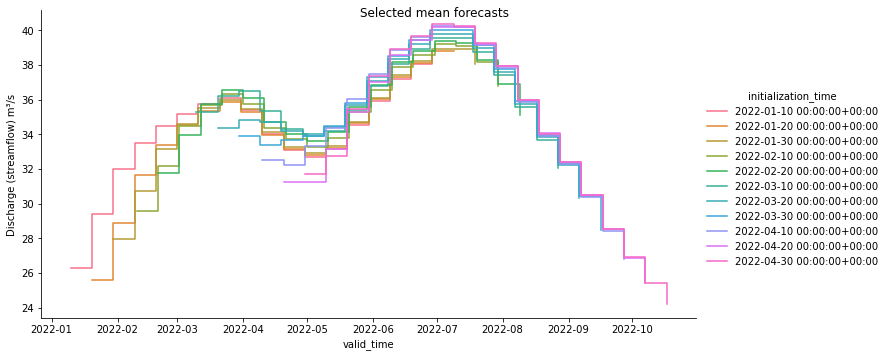

In [7]:
selected_forecasts_df = forecasts_df.loc[
    (forecasts_df["initialization_time"].dt.day % 10 == 0)
    & (  # every 10th day so the plot isn't too cluttered
        forecasts_df["initialization_time"] < "2022-05"
    )
]

g = sns.relplot(
    x="valid_time",
    y="discharge_mean",  # plot the mean of the forecast probability distribution
    hue="initialization_time",  # color each forecast separately
    kind="line",
    height=5,
    aspect=2,
    drawstyle="steps-post",  # forecast values represent the average across each 10 day step
    data=selected_forecasts_df,
)
g.fig.suptitle("Selected mean forecasts")
g.set_axis_labels(y_var="Discharge (streamflow) m³/s");

Each forecast also comes with a full probability distribution describing the range of possible flows. Let's shade the regions in the model's 50% and 95% confidence intervals.

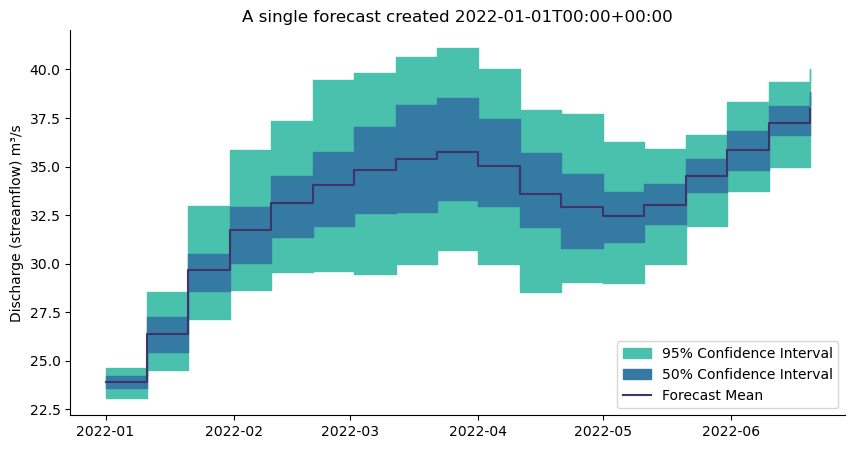

In [8]:
initialization_time = "2022-01-01T00:00+00:00"
forecast_df = forecasts_df.loc[
    forecasts_df["initialization_time"] == initialization_time
]

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("mako_r", n_colors=3)

# The 95% confidence interval ranges from quantile 0.025 through quantile 0.975
ax.fill_between(
    forecast_df["valid_time"],
    forecast_df["discharge_q0.025"],
    forecast_df["discharge_q0.975"],
    label="95% Confidence Interval",
    step="post",
    color=colors[0],
)
# The 50% confidence interval ranges from quantile 0.25 through quantile 0.75
ax.fill_between(
    forecast_df["valid_time"],
    forecast_df["discharge_q0.25"],
    forecast_df["discharge_q0.75"],
    label="50% Confidence Interval",
    step="post",
    color=colors[1],
)
ax.plot(
    forecast_df["valid_time"],
    forecast_df["discharge_mean"],
    label="Forecast Mean",
    drawstyle="steps-post",
    color=colors[2],
)

ax.set_title(f"A single forecast created {initialization_time}")
ax.set_ylabel("Discharge (streamflow) m³/s")
ax.legend(loc="lower right")

sns.despine()